In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path[:]
sys.path.insert(0, '/mnt/home/landerson/src/')
sys.path.insert(0, '/mnt/home/landerson/.local/lib/python3.6/site-packages')
#import pynbody
#sys.path.insert(0, '/Users/landerson/src/')
import gizmo_read
import rotate_gizmo
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.units as u
from astropy.constants import c, m_p, M_sun
import yt
from yt.units import kpc, kiloparsec, Msun 
import glob
from PyPDF2 import PdfFileMerger
import os 
import pandas as pd
import imageio
from scipy.stats import norm
from matplotlib import cm

/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib.colors import LogNorm

In [4]:
import glob
from PyPDF2 import PdfFileMerger
 
def merger(output_path, input_paths):
    pdf_merger = PdfFileMerger()
    file_handles = []
 
    for path in input_paths:
        pdf_merger.append(path)
 
    with open(output_path, 'wb') as fileobj:
        pdf_merger.write(fileobj)
        
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(mappable, ax, label=None):
    """ sol'n from https://joseph-long.com/writing/colorbars/"""
    #ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax, label=label)


In [5]:
yt.__version__

'4.0.dev0'

In [6]:
simname = 'm12f'
directory = '/mnt/ceph/users/firesims/ananke/Latte/' + simname + '/'
part = gizmo_read.read.Read.read_snapshot(species='gas', 
                                          properties= ['position', 'velocity', 
                                                       'mass', 'massfraction', 
                                                       'density', 'hydrogen.neutral.fraction',
                                                       'smooth.length'], 
                                          directory=directory)
gizmo_read.read.Read.read_lsr_coordinates(part, directory='.', lsr_index=2)
part['gas']['position'] = part['gas']['position'] - part.lsr_position
part['gas']['velocity'] = part['gas']['velocity'] - part.lsr_velocity

reading header from:
  /mnt/ceph/users/firesims/ananke/Latte/m12f/snapdir_600/snapshot_600.0.hdf5

snapshot contains the following number of particles:
  gas    (id = 0): 80307825 particles

reading gas properties:
  ['density', 'hydrogen.neutral.fraction', 'mass', 'massfraction', 'position', 'smooth.length', 'velocity']

reading particles from:
  snapshot_600.0.hdf5
  snapshot_600.1.hdf5
  snapshot_600.2.hdf5
  snapshot_600.3.hdf5

reading galaxy center coordinates and principal axes from:  mnt/ceph/users/firesims/ananke/Latte/m12f/m12f_res7100_center.txt
  center position [kpc] = 38711.761, 47665.072, 46817.265
  center velocity [km/s] = -154.5, 160.9, 106.8

adjusting particle coordinates to be relative to galaxy center
  and aligned with the principal axes

reading LSR coordinates from:
  m12f_res7100_LSR2.txt
  LSR_2 position [kpc] = 7.101, -4.100, 0.000
  LSR_2 velocity [km/s] = -118.1, -187.8, -3.9



In [17]:
scale = 10 #kpc
indices = np.all(np.abs(part['gas']['position']) < scale, axis=1)

In [18]:
np.sum(indices)

897744

In [22]:
part['gas']['position'][:, 0] = -1.*part['gas']['position'][:, 0]
part['gas']['position'][:, 1] = -1.*part['gas']['position'][:, 1]

In [25]:
np.savez('latte10kpc', x = part['gas']['position'][:,0][indices], 
                       y = part['gas']['position'][:,1][indices], 
                       z = part['gas']['position'][:,2][indices],
                position = part['gas']['position'][indices],
                velocity = part['gas']['velocity'][indices],
                    mass = part['gas']['mass'][indices],
            massfraction = part['gas']['massfraction'][indices],
                 density = part['gas']['density'][indices],
 hydrogenneutralfraction = part['gas']['hydrogen.neutral.fraction'][indices],
            smoothlength = part['gas']['smooth.length'][indices],
        metallicitytotal = part['gas']['metallicity.total'][indices],
        snapshottime = part.snapshot['time'],
        boxlength = part.info['box.length'])


In [24]:
part.snapshot['time']

13.798746882657937

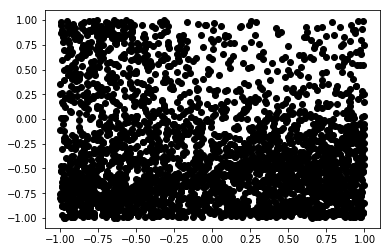

In [12]:
plt.plot(part['gas']['position'][:,0][indices], part['gas']['position'][:,1][indices], 'ko')

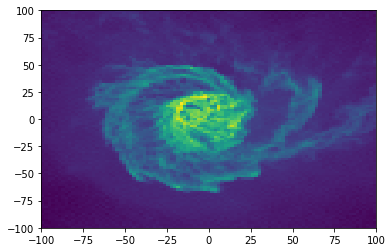

In [8]:
#gas face on
plt.hist2d(part['gas']['position'][:,0],part['gas']['position'][:,1],bins=np.linspace(-100,100,100),norm = LogNorm());

In [11]:
#stars edge on
#plt.hist2d(part['star']['position'][:,0],part['star']['position'][:,2],bins=np.linspace(-10,10,100),norm = LogNorm());

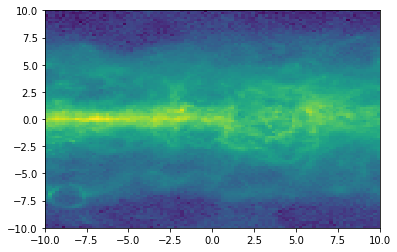

In [10]:
#gas edge on
plt.hist2d(part['gas']['position'][:,0],part['gas']['position'][:,2],bins=np.linspace(-10,10,100),norm = LogNorm());

In [6]:
solarMetallicity = 0.2
massfraction_he = part['gas']['massfraction'][:,1]
massfraction_all  = part['gas']['massfraction'][:,0]
fractionHydrogen = 1. - massfraction_all - massfraction_he
neutralHydrogenMass = part['gas']['mass']*fractionHydrogen*part['gas']['hydrogen.neutral.fraction']
metalWeightedNeutralHydrogenMass = neutralHydrogenMass*10.**part['gas']['metallicity.total']

neutralHydrogenDensity = part['gas']['density']*fractionHydrogen*part['gas']['hydrogen.neutral.fraction']
metalWeightedNeutralHydrogenDensity = neutralHydrogenDensity*10.**part['gas']['metallicity.total']


In [7]:
scale = 0.25 #kpc
inbox = np.all(np.abs(part['gas']['position']) < scale, axis=1)

In [8]:
metalWeightedNeutralHydrogenDensity[inbox]/(1e3)**3

array([0.00807979, 0.0001783 , 0.00825771, 0.00538572, 0.00724703,
       0.00703115, 0.00481343, 0.00943928, 0.00961652, 0.00785021,
       0.01462158, 0.00411991, 0.0034069 , 0.00693849, 0.0060313 ,
       0.00440061, 0.01586063, 0.0086198 , 0.00314459, 0.00270518,
       0.01859986, 0.00771001, 0.02478655, 0.00727987, 0.02214564,
       0.01807957, 0.01354655, 0.00914507, 0.02771958, 0.0262027 ,
       0.01371938, 0.04777254, 0.13192588, 0.03143638, 0.01978746,
       0.01605615, 0.00347627, 0.01570161, 0.02029467, 0.03032327,
       0.01039992, 0.01559907, 0.03144442, 0.02230322, 0.01743132,
       0.00247405, 0.00707823, 0.00287924, 0.00069366], dtype=float32)

In [9]:
import h5py
f = h5py.File('distance2kpc_snp5_lsr2_m12f.hdf5', mode='r')

In [10]:
def grab_slice(data, xscale, yscale, zscale):
    return (np.abs(data['px_true']) < xscale) & (np.abs(data['py_true']) < yscale) &(np.abs(data['pz_true']) < zscale)

In [11]:
inslice = grab_slice(f['data'], 1, 1, 0.01)

In [12]:
f['data']['A0'][inslice]

array([0.02943628, 0.05088146, 0.04412584, ..., 0.13497843, 0.01595265,
       0.13737679])

## Calculate metallicity weighted density

In [13]:
from yt.units import dimensions
def _metal_weighted_density(field, data):
    solarMetallicity = 0.2
    massfraction_he = data['massfraction_he']
    massfraction_all  = data['massfraction_all']
    fractionHydrogen = 1. - massfraction_all - massfraction_he
    neutralHydrogenMass = data['density']*fractionHydrogen*data['hydrogen_neutral_fraction']
    metalWeightedNeutralHydrogenMass = neutralHydrogenMass*10.**data['metallicity']
    return metalWeightedNeutralHydrogenMass

yt.add_field(("io","dustDensity"), function=_metal_weighted_density, units='Msun/pc**3', #units="auto", 
             dimensions=dimensions.density, sampling_type='particle', force_override=True)

In [14]:
Q = 2.5e22 #H/cm2/mag
EBV = 1/3.1
m_p = 1.6726219e-24 #g
length_unit=3.08567758149137e21 #kpc to cm  
mass_unit=1.98847e33 #solar mass to g 
time_unit=3.15576e16 #Gyr to s, 
velocity_unit=1e5 #km to cm   
unit_system="galactic" #'cgs'
sim_time = part.snapshot['time']*time_unit
field = 'io'

In [15]:
data = {(field, 'particle_position_x'): np.array(part['gas']['position'][:,0], dtype='float64'),
        (field, 'particle_position_y'): np.array(part['gas']['position'][:,1], dtype='float64'),
        (field, 'particle_position_z'): np.array(part['gas']['position'][:,2], dtype='float64'),
        (field, 'particle_velocity_x'): np.array(part['gas']['velocity'][:,0], dtype='float64'),
        (field, 'particle_velocity_y'): np.array(part['gas']['velocity'][:,1], dtype='float64'),
        (field, 'particle_velocity_z'): np.array(part['gas']['velocity'][:,2], dtype='float64'),
        (field, 'density'):    np.array(part['gas']['density'], dtype='float64'),
        (field, 'hydrogen_neutral_fraction'): np.array(part['gas']['hydrogen.neutral.fraction'], dtype='float64'),
        (field, 'massfraction_he'): np.array(part['gas']['massfraction'][:,1], dtype='float64'),
        (field, 'massfraction_all'): np.array(part['gas']['massfraction'][:,0], dtype='float64'),
        (field, 'metallicity'): np.array(part['gas']['metallicity.total'], dtype='float64'),
        (field, 'smoothing_length'): np.array(part['gas']['smooth.length'], dtype='float64'),
        (field, 'particle_mass'): np.array(part['gas']['mass'], dtype='float64')
        }
half_box = part.info['box.length']/2.*length_unit
bbox = np.array([[-half_box, half_box], [-half_box, half_box], [-half_box, half_box]])

ds = yt.load_particles(data, length_unit=length_unit, mass_unit=mass_unit, velocity_unit=velocity_unit, 
                       time_unit=time_unit, bbox=bbox, unit_system=unit_system, sim_time=sim_time)

yt : [INFO     ] 2019-04-18 14:34:34,753 Parameters: current_time              = 4.3545533462416614e+17
yt : [INFO     ] 2019-04-18 14:34:34,754 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2019-04-18 14:34:34,755 Parameters: domain_left_edge          = [-1.31866563e+26 -1.31866563e+26 -1.31866563e+26]
yt : [INFO     ] 2019-04-18 14:34:34,756 Parameters: domain_right_edge         = [1.31866563e+26 1.31866563e+26 1.31866563e+26]
yt : [INFO     ] 2019-04-18 14:34:34,757 Parameters: cosmological_simulation   = 0.0


In [16]:
scale = 0.25
ninduce = 15625 #125
nxstar = 25
grid_number = nxstar
dir = '/mnt/home/landerson/dust-map/src/'
ndata = '100000'
x = np.linspace(-scale, scale, grid_number)


In [17]:
edge = scale + 0.5*scale/grid_number
gizmoxbins = np.linspace(-edge, edge, grid_number+1)
gizmoybins = np.linspace(-edge, edge, grid_number+1)
gizmozbins = np.linspace(-edge, edge, grid_number+1)

gizmoDust, gizmoEdges = np.histogramdd(part['gas']['position'],
                           weights=metalWeightedNeutralHydrogenMass, 
                           bins=[gizmoxbins, gizmoybins, gizmozbins])
gizmoCellVolume = (gizmoxbins[1] - gizmoxbins[0])*(gizmoybins[1]-gizmoybins[0])*(gizmozbins[1]-gizmozbins[0])
gizmoDustDensity = gizmoDust/gizmoCellVolume



In [18]:
np.sum(np.sqrt(np.sum(part['gas']['position']**2., axis=1)) < 0.25)

33

In [19]:
x = np.linspace(-scale, scale, grid_number)
xx, yy = np.meshgrid(x, x)
left_edge = [-scale, -scale, -scale]*kpc
right_edge = [scale, scale, scale]*kpc
ag = ds.arbitrary_grid(left_edge, right_edge, dims=[grid_number]*3)
dustDensity = ag[('io', 'dustDensity')]

yt : [INFO     ] 2019-04-18 14:34:47,394 Allocating for 8.031e+07 particles


In [20]:
def make_qq_comparison(intvalues, ax=None, name=None, color='black'):
    if ax is None: fig, ax = plt.subplots()
    pgrid = np.arange(1, len(intvalues)+1) / (len(intvalues)+1)
    z_norm = norm.ppf(pgrid)
    z_meth = (intvalues['etest'].values - intvalues['mu_test'].values) / intvalues['esig'].values
    ax.plot(z_norm, np.sort(z_meth), label=name, lw=2, color=color) #np.array(cm[:,np.newaxis]).T)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.plot([-3, 3], [-3, 3], color='black', alpha=0.5, lw=2)
    ax.legend()
    ax.set_xlabel('Normal Theoretical Quantiles')
    ax.set_ylabel('Normal Data Quantiles')

In [21]:
def make_qq_comparison_other(etest, mutest, esig, ax=None, name=None, color='black'):
    if ax is None: fig, ax = plt.subplots()
    pgrid = np.arange(1, len(etest)+1) / (len(etest)+1)
    z_norm = norm.ppf(pgrid)
    z_meth = (etest - mutest) / esig
    ax.plot(z_norm, np.sort(z_meth), label=name, lw=2, color=color) #np.array(cm[:,np.newaxis]).T)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.plot([-3, 3], [-3, 3], color='black', alpha=0.5, lw=2)
    ax.legend()
    ax.set_xlabel('Normal Theoretical Quantiles')
    ax.set_ylabel('Normal Data Quantiles')

In [57]:
#feed it mu_grid[plane], sig2_grid[plane], xx1[plane], xx2[plane], xobs[near plane], aobs[near plane]
def plot_comparison_ananke(ananke_A, ananke_x, ananke_y, yt_dustdensity, gizmo_dustdensity,
                    smooth=True, vmin=None, vmax=None, scale=1.0):
    
    xlo, xhi = -scale, scale
    ylo, yhi = -scale, scale

    
    if smooth:
        plotfun = lambda f, ax, vmin=vmin, vmax=vmax: ax.imshow(
            f.reshape(grid_x.shape), origin='lower',
            extent=(xlo, xhi, ylo, yhi), interpolation='bilinear',
            vmin=vmin, vmax=vmax, cmap=plt.get_cmap('viridis'))
    else:
        plotfun = lambda f, ax, vmin=vmin, vmax=vmax: ax.contourf(
            grid_x, grid_y, f.reshape(grid_x.shape), vmin=vmin, vmax=vmax, cmap=plt.get_cmap('viridis'))

    fig, axarr = plt.subplots(1,3, figsize=(20,5))
    #ax = axarr[0]
    #cs = ax.scatter(ananke_x, ananke_y, s=1, c=ananke_A, cmap=plt.get_cmap('Blues'), vmin=None, vmax=None)
    #cs.set_rasterized(True)
    #colorbar(cs, ax, label='$A_0$')
    #ax.scatter(xobs[:,0], xobs[:,1], c='black', s=2)
    #ax.scatter(0, 0, c='red', s=100)
    #ax.axis('equal')
    #ax.set_xlim(-scale,scale)
    #ax.set_ylim(-scale,scale)
    #ax.set_xlabel('X')
    #ax.set_ylabel('Y')
    #ax.set_title("True integrated rho(x)")

    ax = axarr[0]
    h, xe, ye, bincount = binned_statistic_2d(ananke_x, ananke_y, ananke_A, bins=100, statistic='mean')
    h[np.isnan(h)] = 0.0
    cs = ax.pcolormesh(xe, ye, h.T, cmap=plt.get_cmap('Blues'), vmin=None, vmax=None)
    cs.set_rasterized(True)
    colorbar(cs, ax, label='$A_0$')
    #ax.scatter(xobs[:,0], xobs[:,1], c='black', s=2)
    ax.scatter(0, 0, c='red', s=100)
    ax.axis('equal')
    ax.set_xlim(-scale,scale)
    ax.set_ylim(-scale,scale)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title("True integrated rho(x)")

    
    ax = axarr[1]
    cs = plotfun(yt_dustdensity, ax, vmin=None, vmax=None)
    if smooth: cs.set_rasterized(True)
    colorbar(cs, ax, label='$M_\odot/pc^3$')
    ax.set_xlim(-scale,scale)
    ax.set_ylim(-scale,scale)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title("YT dust density")
    
    
    ax = axarr[2]
    cs = plotfun(gizmo_dustdensity, ax, vmin=None, vmax=None)
    if smooth: cs.set_rasterized(True)
    colorbar(cs, ax, label='$M_\odot/pc^3$')
    ax.set_xlim(-scale,scale)
    ax.set_ylim(-scale,scale)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title("Gizmo dust density")

    fig.tight_layout()
    return fig, axarr

In [38]:
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d

In [24]:
ananke_A = f['data']['A0']
ananke_x = f['data']['px_true']
ananke_y = f['data']['py_true']
ananke_z = f['data']['pz_true']


In [58]:
scale = 1.0 #kpc

obs_thick = 0.01 
inplane_ananke = grab_slice(f['data'], scale, scale, obs_thick)

inbox = (np.abs(part['gas']['position'][:,0]) < scale) & (np.abs(part['gas']['position'][:,1]) < scale) & (np.abs(part['gas']['position'][:,2]) < obs_thick)
grid_x, grid_y = np.mgrid[-scale:scale:100j, -scale:scale:100j]
gizmo_dustdensity = griddata(part['gas']['position'][:,:-1][inbox],
                             metalWeightedNeutralHydrogenDensity[inbox]/(1e3)**3, 
                             (grid_x, grid_y), method='cubic')

left_edge = [-scale, -scale, -obs_thick]*kpc
right_edge = [scale, scale, obs_thick]*kpc
ag = ds.arbitrary_grid(left_edge, right_edge, dims=[100, 100, 3])
dustDensity = ag[('io', 'dustDensity')]
yt_dustdensity = dustDensity[:,:,1]



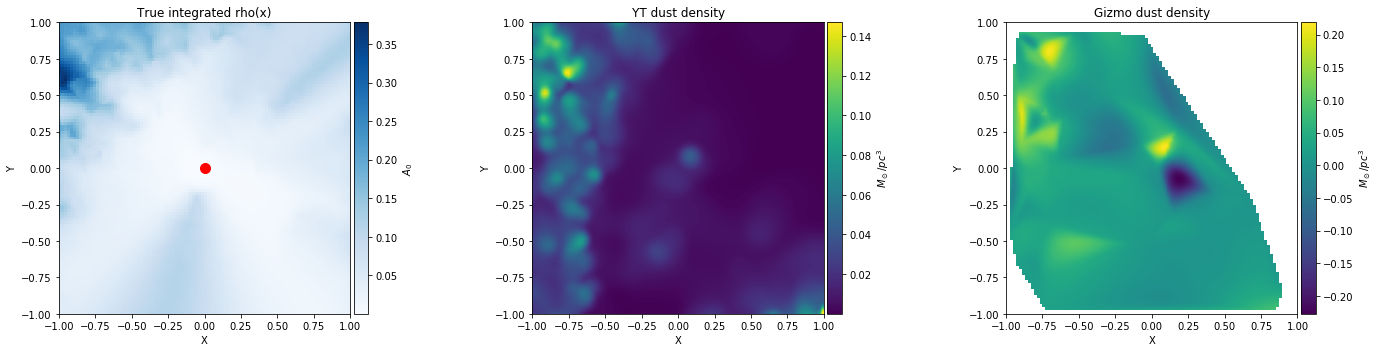

In [59]:
fig, axarr = plot_comparison_ananke(ananke_A[inplane_ananke], ananke_x[inplane_ananke], ananke_y[inplane_ananke], 
                       yt_dustdensity, gizmo_dustdensity,
                    smooth=True, vmin=None, vmax=None, scale=scale)


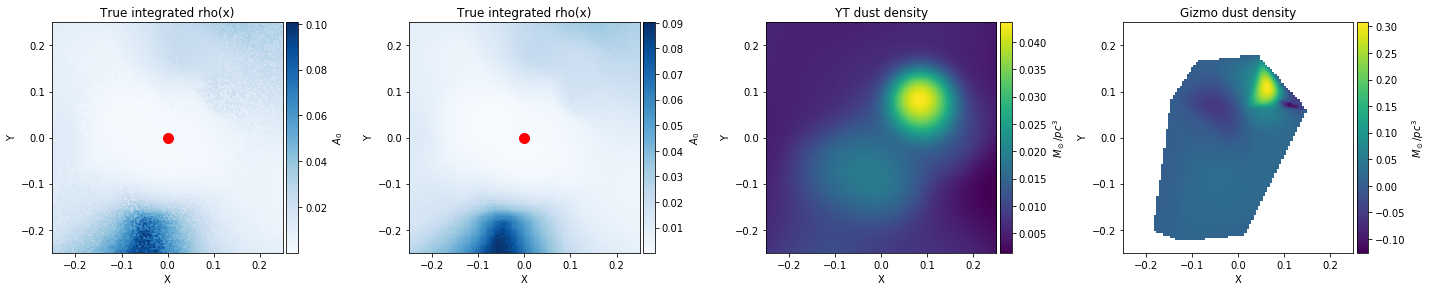

In [40]:
scale = 0.25 #kpc

obs_thick = 0.05 
inplane_ananke = grab_slice(f['data'], scale, scale, obs_thick)

inbox = (np.abs(part['gas']['position'][:,0]) < scale) & (np.abs(part['gas']['position'][:,1]) < scale) & (np.abs(part['gas']['position'][:,2]) < obs_thick)
grid_x, grid_y = np.mgrid[-scale:scale:100j, -scale:scale:100j]
gizmo_dustdensity = griddata(part['gas']['position'][:,:-1][inbox],
                             metalWeightedNeutralHydrogenDensity[inbox]/(1e3)**3, 
                             (grid_x, grid_y), method='cubic')

left_edge = [-scale, -scale, -obs_thick]*kpc
right_edge = [scale, scale, obs_thick]*kpc
ag = ds.arbitrary_grid(left_edge, right_edge, dims=[100, 100, 1])
dustDensity = ag[('io', 'dustDensity')]
yt_dustdensity = dustDensity
fig, axarr = plot_comparison_ananke(ananke_A[inplane_ananke], ananke_x[inplane_ananke], ananke_y[inplane_ananke], 
                       yt_dustdensity, gizmo_dustdensity,
                    smooth=True, vmin=None, vmax=None, scale=scale)


In [45]:
h, xe, ye, bincount = binned_statistic_2d(ananke_x[inplane_ananke], ananke_y[inplane_ananke], ananke_A[inplane_ananke], bins=100)

In [47]:
h.min()

nan

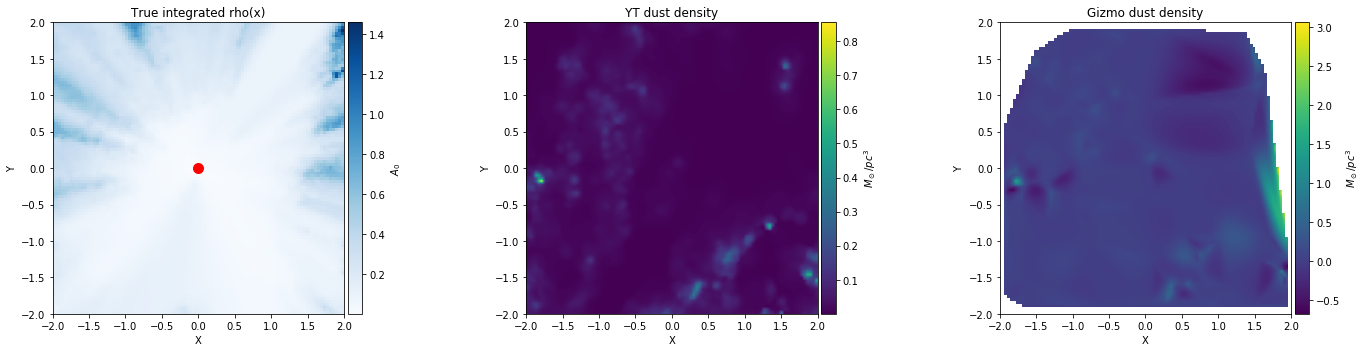

In [53]:
scale = 2.0 #kpc

obs_thick = 0.01 
inplane_ananke = grab_slice(f['data'], scale, scale, obs_thick)

inbox = (np.abs(part['gas']['position'][:,0]) < scale) & (np.abs(part['gas']['position'][:,1]) < scale) & (np.abs(part['gas']['position'][:,2]) < obs_thick)
grid_x, grid_y = np.mgrid[-scale:scale:100j, -scale:scale:100j]
gizmo_dustdensity = griddata(part['gas']['position'][:,:-1][inbox],
                             metalWeightedNeutralHydrogenDensity[inbox]/(1e3)**3, 
                             (grid_x, grid_y), method='cubic')

left_edge = [-scale, -scale, -obs_thick]*kpc
right_edge = [scale, scale, obs_thick]*kpc
ag = ds.arbitrary_grid(left_edge, right_edge, dims=[100, 100, 1])
dustDensity = ag[('io', 'dustDensity')]
yt_dustdensity = dustDensity
fig, axarr = plot_comparison_ananke(ananke_A[inplane_ananke], ananke_x[inplane_ananke], ananke_y[inplane_ananke], 
                       yt_dustdensity, gizmo_dustdensity,
                    smooth=True, vmin=None, vmax=None, scale=scale)


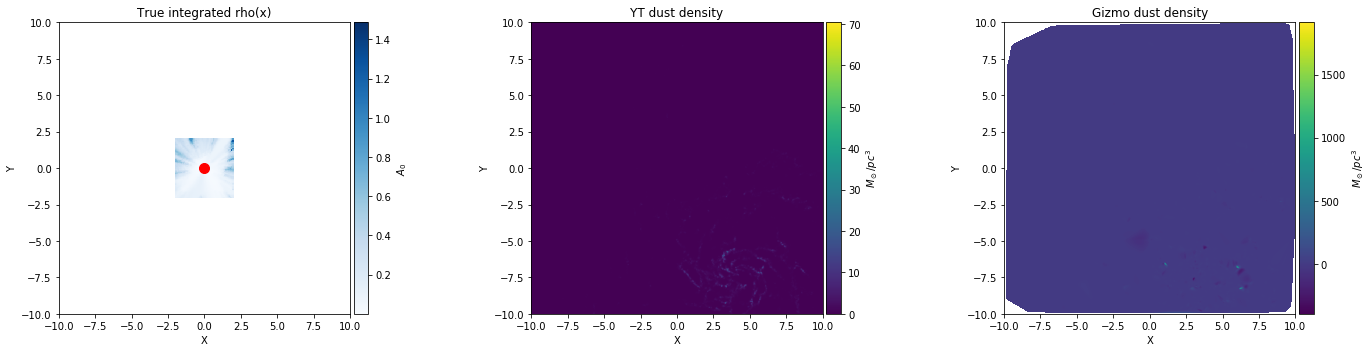

In [52]:
scale = 10.0 #kpc

obs_thick = 0.005 
inplane_ananke = grab_slice(f['data'], scale, scale, obs_thick)

inbox = (np.abs(part['gas']['position'][:,0]) < scale) & (np.abs(part['gas']['position'][:,1]) < scale) & (np.abs(part['gas']['position'][:,2]) < obs_thick)
grid_x, grid_y = np.mgrid[-scale:scale:1000j, -scale:scale:1000j]
gizmo_dustdensity = griddata(part['gas']['position'][:,:-1][inbox],
                             metalWeightedNeutralHydrogenDensity[inbox]/(1e3)**3, 
                             (grid_x, grid_y), method='cubic')

left_edge = [-scale, -scale, -obs_thick]*kpc
right_edge = [scale, scale, obs_thick]*kpc
ag = ds.arbitrary_grid(left_edge, right_edge, dims=[1000, 1000, 1])
dustDensity = ag[('io', 'dustDensity')]
yt_dustdensity = dustDensity
fig, axarr = plot_comparison_ananke(ananke_A[inplane_ananke], ananke_x[inplane_ananke], ananke_y[inplane_ananke], 
                       yt_dustdensity, gizmo_dustdensity,
                    smooth=True, vmin=None, vmax=None, scale=scale)


In [44]:
f['data']['A0'].min()

7.413643476894549e-09

In [ ]:
plot the average A values

In [ ]:
plot A values as function of x, y, z and see if blob pops 

In [32]:
np.sum(inplane_ananke)

780603

In [30]:
print('yes')

yes


In [65]:
random_factor = 50.
A_to_dust_density = Q*EBV*m_p*(length_unit)**2/mass_unit/random_factor/1e9                                 

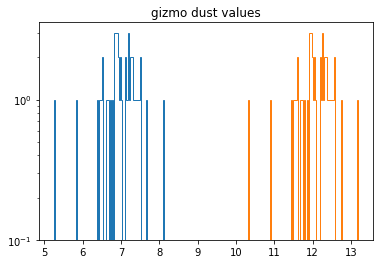

In [66]:
plt.hist(np.log10(gizmoDust[gizmoDust > 0]), bins=100, histtype='step', log=True)
plt.hist(np.log10(gizmoDustDensity[gizmoDustDensity > 0]), bins=100, histtype='step', log=True)
plt.title('gizmo dust values')

In [46]:
intvalues.keys()

Index(['etest', 'noisy_etest', 'x', 'y', 'z', 'mu_test', 'esig', 'asig'], dtype='object')

In [53]:
dustfield.keys()

Index(['x', 'y', 'z', 'mu_pred', 'sig_pred'], dtype='object')

In [48]:
figqq, axqq = plt.subplots()
viridis = cm.get_cmap('viridis')
colors = viridis(np.linspace(0, 1, len(munames)))

for muname, c in zip(munames, colors): 
    for i in range(nxstar):
        position = i
        obs_thick = 1./nxstar*2.
        scale = 1.
        inplane_ananke = grab_slice(f['data'], scale, scale, obs_thick)
        inplane  = np.abs(intvalues['z'] - predz[:,:,position].min()) < obs_thick
        smooth = True
        inplaneGizmo = np.abs(part['gas']['position'][:,2] - predz[:,:,position].min()) < 0.1
        gizmoDust, gizmoxEdges, gizmoyEdges = np.histogram2d(part['gas']['position'][:,0][inplaneGizmo],
                                                             part['gas']['position'][:,1][inplaneGizmo],
                           weights=metalWeightedNeutralHydrogenMass[inplaneGizmo], 
                           bins=[gizmoxbins, gizmoybins])
        
        fig, axarr = plot_comparison(intvalues['mu_test'].values[inplane], 
                                     intvalues['asig'].values[inplane], 
                                     predmu[:,:,position], 
                                     predsig2[:,:,position],
                                     predx[:,:,position], 
                                     predy[:,:,position],
                                     intvalues['etest'].values[inplane], 
                                     intvalues['x'].values[inplane],
                                     intvalues['y'].values[inplane],
                                     dustDensity[:,:,position],
                                     gizmoDust,
                                     smooth=smooth, vmin=None, vmax=None, scale=scale)
        #axarr[2].scatter(xinduce[inplaneind,0], xinduce[inplaneind, 1], c='black')
        axarr[0].axis('equal')
        axarr[0].set_xlim(-scale, scale)
        axarr[0].set_ylim(-scale, scale)

        fig.savefig('gpdust_{0}_{1:03d}.pdf'.format(name, i), rasterized=True)
        fig.savefig('gpdust_{0}_{1:03d}.png'.format(name, i))
        plt.close(fig)


    paths = glob.glob('gpdust_{0}_*.pdf'.format(name))
    paths.sort()
    merger('gpdust_{0}.pdf'.format(name), paths)
    for p in paths: os.remove(p)
    images = []
    paths = glob.glob('gpdust_{0}_*.png'.format(name))
    paths.sort()
    for p in paths: images.append(imageio.imread(p))
    paths = paths[::-1]
    for p in paths: images.append(imageio.imread(p))    
    imageio.mimsave('gpdust_{0}.gif'.format(name), images)
    for p in paths: os.remove(p)

    
figqq.savefig('qq_0.5kpc.pdf')

'mu_pred'

Index(['x', 'y', 'z', 'mu_pred', 'sig_pred'], dtype='object')


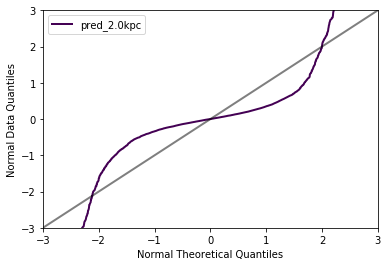

In [69]:
#dustfield = pd.read_pickle(dir + 'dustfield_15625inducing_16thetas_0.5kpc.pkl')
#intvalues = pd.read_pickle(dir + 'dust_15625inducing_16thetas_0.5kpc.pkl')

dustfield = pd.read_pickle(dir + 'dustf_15625inducing_12thetas_2.0kpc_100000ndata_sig100.000_ell0.010.pkl')
intvalues = pd.read_pickle(dir + 'dustint_15625inducing_12thetas_2.0kpc_100000ndata_sig100.000_ell0.010.pkl')

munames = dustfield.keys()[['mu' in k for k in dustfield.keys()]]                      

predx = dustfield['x'].values.reshape(nxstar, nxstar, nxstar)
predy = dustfield['y'].values.reshape(nxstar, nxstar, nxstar)
predz = dustfield['z'].values.reshape(nxstar, nxstar, nxstar)

figqq, axqq = plt.subplots()
viridis = cm.get_cmap('viridis')
colors = viridis(np.linspace(0, 1, len(munames)))

for muname, c in zip(munames, colors): 
    chunks = muname.split('_')
    name = ' '.join([*chunks[1:]])+'_2.0kpc'
    predmu = dustfield['mu_pred'].values.reshape(nxstar, nxstar, nxstar)*A_to_dust_density
    predsig2 = dustfield['sig_pred'].values.reshape(nxstar, nxstar, nxstar)*A_to_dust_density**2
    print(dustfield.keys())
    make_qq_comparison_other(intvalues['etest'].values, intvalues['mu_test'].values, intvalues['asig'].values, ax=axqq, name=name, color=c)
    for i in range(nxstar):
        position = i
        obs_thick = 1./nxstar*2.
        scale = 1.
        inplane_ananke = grab_slice(f['data'], scale, scale, obs_thick)
        inplane  = np.abs(intvalues['z'] - predz[:,:,position].min()) < obs_thick
        smooth = True
        inplaneGizmo = np.abs(part['gas']['position'][:,2] - predz[:,:,position].min()) < 0.1
        gizmoDust, gizmoxEdges, gizmoyEdges = np.histogram2d(part['gas']['position'][:,0][inplaneGizmo],
                                                             part['gas']['position'][:,1][inplaneGizmo],
                           weights=metalWeightedNeutralHydrogenMass[inplaneGizmo], 
                           bins=[gizmoxbins, gizmoybins])
        
        fig, axarr = plot_comparison(intvalues['mu_test'].values[inplane], 
                                     intvalues['asig'].values[inplane], 
                                     predmu[:,:,position], 
                                     predsig2[:,:,position],
                                     predx[:,:,position], 
                                     predy[:,:,position],
                                     intvalues['etest'].values[inplane], 
                                     intvalues['x'].values[inplane],
                                     intvalues['y'].values[inplane],
                                     dustDensity[:,:,position],
                                     gizmoDust,
                                     smooth=smooth, vmin=None, vmax=None, scale=scale)
        #axarr[2].scatter(xinduce[inplaneind,0], xinduce[inplaneind, 1], c='black')
        axarr[0].axis('equal')
        axarr[0].set_xlim(-scale, scale)
        axarr[0].set_ylim(-scale, scale)

        fig.savefig('gpdust_{0}_{1:03d}.pdf'.format(name, i), rasterized=True)
        fig.savefig('gpdust_{0}_{1:03d}.png'.format(name, i))
        plt.close(fig)


    paths = glob.glob('gpdust_{0}_*.pdf'.format(name))
    paths.sort()
    merger('gpdust_{0}.pdf'.format(name), paths)
    for p in paths: os.remove(p)
    images = []
    paths = glob.glob('gpdust_{0}_*.png'.format(name))
    paths.sort()
    for p in paths: images.append(imageio.imread(p))
    paths = paths[::-1]
    for p in paths: images.append(imageio.imread(p))    
    imageio.mimsave('gpdust_{0}.gif'.format(name), images)
    for p in paths: os.remove(p)

    
figqq.savefig('qq_0.5kpc.pdf')

In [56]:
name

'pred_2.0kpc'

Index(['x', 'y', 'z', 'mu_sig10.000_ell0.001', 'asig_sig10.000_ell0.001',
       'mu_sig100.000_ell0.001', 'asig_sig100.000_ell0.001',
       'mu_sig1000.000_ell0.001', 'asig_sig1000.000_ell0.001',
       'mu_sig10000.000_ell0.001', 'asig_sig10000.000_ell0.001',
       'mu_sig10.000_ell0.010', 'asig_sig10.000_ell0.010',
       'mu_sig100.000_ell0.010', 'asig_sig100.000_ell0.010'],
      dtype='object')


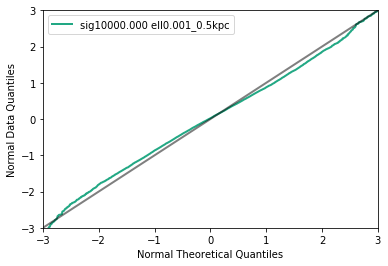

In [70]:
dustfield = pd.read_pickle(dir + 'dustfield_15625inducing_16thetas_0.5kpc.pkl')
intvalues = pd.read_pickle(dir + 'dust_15625inducing_16thetas_0.5kpc.pkl')
munames = dustfield.keys()[['mu' in k for k in dustfield.keys()]]                      

predx = dustfield['x'].values.reshape(nxstar, nxstar, nxstar)
predy = dustfield['y'].values.reshape(nxstar, nxstar, nxstar)
predz = dustfield['z'].values.reshape(nxstar, nxstar, nxstar)

figqq, axqq = plt.subplots()
viridis = cm.get_cmap('viridis')
colors = viridis(np.linspace(0, 1, len(munames)))

for muname, c in zip([munames[4]], [colors[4]]): 
    chunks = muname.split('_')
    name = ' '.join([*chunks[1:]])+'_0.5kpc'
    etname = '_'.join(('etest', *chunks[1:]))
    esname = '_'.join(('esig', *chunks[1:]))
    asname = '_'.join(('asig', *chunks[1:]))
    predmu = dustfield[muname].values.reshape(nxstar, nxstar, nxstar)*A_to_dust_density
    predsig2 = dustfield[asname].values.reshape(nxstar, nxstar, nxstar)*A_to_dust_density**2
    print(dustfield.keys())
    make_qq_comparison_other(intvalues['etest'].values, intvalues[muname].values, intvalues[esname].values, ax=axqq, name=name, color=c)
    for i in range(nxstar):
        position = i
        obs_thick = 1./nxstar*2.
        inplane  = np.abs(intvalues['z'] - predz[:,:,position].min()) < obs_thick
        smooth = True
        inplaneGizmo = np.abs(part['gas']['position'][:,2] - predz[:,:,position].min()) < 0.1
        gizmoDust, gizmoxEdges, gizmoyEdges = np.histogram2d(part['gas']['position'][:,0][inplaneGizmo],
                                                             part['gas']['position'][:,1][inplaneGizmo],
                           weights=metalWeightedNeutralHydrogenMass[inplaneGizmo], 
                           bins=[gizmoxbins, gizmoybins])

        fig, axarr = plot_comparison(intvalues[muname].values[inplane], 
                                     intvalues[asname].values[inplane], 
                                     predmu[:,:,position], 
                                     predsig2[:,:,position],
                                     predx[:,:,position], 
                                     predy[:,:,position],
                                     intvalues['etest'].values[inplane], 
                                     intvalues['x'].values[inplane],
                                     intvalues['y'].values[inplane],
                                     dustDensity[:,:,position],
                                     gizmoDust,
                                     smooth=smooth, vmin=None, vmax=None, scale=scale)
        #axarr[2].scatter(xinduce[inplaneind,0], xinduce[inplaneind, 1], c='black')
        axarr[0].axis('equal')
        axarr[0].set_xlim(-scale, scale)
        axarr[0].set_ylim(-scale, scale)

        fig.savefig('gpdust_{0}_{1:03d}.pdf'.format(name, i), rasterized=True)
        fig.savefig('gpdust_{0}_{1:03d}.png'.format(name, i))
        plt.close(fig)


    paths = glob.glob('gpdust_{0}_*.pdf'.format(name))
    paths.sort()
    merger('gpdust_{0}.pdf'.format(name), paths)
    for p in paths: os.remove(p)
    images = []
    paths = glob.glob('gpdust_{0}_*.png'.format(name))
    paths.sort()
    for p in paths: images.append(imageio.imread(p))
    paths = paths[::-1]
    for p in paths: images.append(imageio.imread(p))    
    imageio.mimsave('gpdust_{0}.gif'.format(name), images)
    for p in paths: os.remove(p)

    
figqq.savefig('qq_0.5kpc.pdf')

In [84]:
figqq.savefig('qq_0.5kpc.pdf')

In [99]:
dustfield = pd.read_pickle(dir + 'dustf_15625inducing_12thetas_2.0kpc_100000ndata_sig316.228_ell0.010.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/home/landerson/dust-map/src/dustf_15625inducing_12thetas_2.0kpc_100000ndata_sig1000.000_ell0.215.pkl'

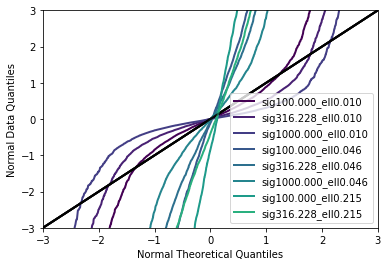

In [119]:
#sig2 = np.logspace(2, 4, 3) #10)
#ell2 = np.logspace(-3, -1, 3) #10)
#ntheta = 9
sig2 = np.logspace(2, 3, 3) #10)
ell2 = np.logspace(-2, 0, 4) #10)
ntheta = 12

XX, YY = np.meshgrid(sig2, ell2)
theta = np.column_stack([XX.flatten(), YY.flatten()])

nxstar = 25
figqq, axqq = plt.subplots()
viridis = cm.get_cmap('viridis')
colors = viridis(np.linspace(0, 1, len(theta)))

for (sig2, ell2) , c in zip(theta, colors):

    dustfield_f = '{0}_{1}inducing_{2}thetas_{3}kpc_{4}ndata_sig{5:.3f}_ell{6:.3f}.pkl'.format('dustf', ninduce, ntheta, scale*2, ndata, sig2, ell2)
    intdustvalues_f = '{0}_{1}inducing_{2}thetas_{3}kpc_{4}ndata_sig{5:.3f}_ell{6:.3f}.pkl'.format('dustint', ninduce, ntheta, scale*2, ndata, sig2, ell2)

    dustfield = pd.read_pickle(dir + dustfield_f)
    intvalues = pd.read_pickle(dir + intdustvalues_f)
    name = 'sig{0:.3f}_ell{1:.3f}'.format(float(sig2), float(ell2))

    predx = dustfield['x'].values.reshape(nxstar, nxstar, nxstar)
    predy = dustfield['y'].values.reshape(nxstar, nxstar, nxstar)
    predz = dustfield['z'].values.reshape(nxstar, nxstar, nxstar)
    predmu = dustfield['mu_pred'].values.reshape(nxstar, nxstar, nxstar)*A_to_dust_density
    predsig2 = dustfield['sig_pred'].values.reshape(nxstar, nxstar, nxstar)*A_to_dust_density**2.
    make_qq_comparison(intvalues, ax=axqq, name=name, color=c)
    for i in range(nxstar):
        position = i
        obs_thick = 1./nxstar*2.
        inplane  = np.abs(intvalues['z'] - predz[:,:,position].min()) < obs_thick
        smooth = True
        #inplaneind = np.abs(xinduce[:,2] - xstar[position,2]) < obs_thick
        fig, axarr = plot_comparison(intvalues['mu_test'].values[inplane], 
                                     intvalues['asig'].values[inplane], 
                                     predmu[:,:,position], 
                                     predsig2[:,:,position],
                                     predx[:,:,position], 
                                     predy[:,:,position],
                                     intvalues['etest'].values[inplane], 
                                     intvalues['x'].values[inplane],
                                     intvalues['y'].values[inplane],
                                     dustDensity[:,:,position],
                                     smooth=smooth, vmin=None, vmax=None, scale=scale)
        #axarr[2].scatter(xinduce[inplaneind,0], xinduce[inplaneind, 1], c='black')
        axarr[0].axis('equal')
        axarr[0].set_xlim(-scale, scale)
        axarr[0].set_ylim(-scale, scale)

        fig.savefig('gpdust_{0}_{1:03d}.pdf'.format(name, i), rasterized=True)
        fig.savefig('gpdust_{0}_{1:03d}.png'.format(name, i))
        plt.close(fig)


    paths = glob.glob('gpdust_{0}_*.pdf'.format(name))
    paths.sort()
    merger('gpdust_{0}.pdf'.format(name), paths)
    for p in paths: os.remove(p)
    images = []
    paths = glob.glob('gpdust_{0}_*.png'.format(name))
    paths.sort()
    for p in paths: images.append(imageio.imread(p))
    paths = paths[::-1]
    for p in paths: images.append(imageio.imread(p))    
    imageio.mimsave('gpdust_{0}.gif'.format(name), images)
    for p in paths: os.remove(p)

    
figqq.savefig('qq_2kpc.pdf')





In [118]:
figqq.savefig('qq_2kpc.pdf')